# Individual Project Submission for ENG5337
Due date: 28th February 2025

Artificial Intelligence (AI) and Machine Learning (ML) are revolutionizing the field of robotics. This project aims to provide hands-on experience in developing and evaluating AI/ML algorithms for a line-following robot using the Quanser Qbot simulated environment. In this project, students will consider the requirements for deploying AI/ML algorithms in a robotics environment and how to measure their performance.

## Instructions

Students should complete each section of this notbook. Notes:
* Text enclosed in """triple quotes""" should be replaced with the students own text.
* The Python functions should be developed to integrate with the Quanser Python scripts. As such, they may need adjusted to run independently in this notebook. An example of this is shown in task A4.
* In Section B2, plots should be embedded in the notebook as images - syntax for doing this is included below. Please remember to upload the relevant image files along with your submission. Failure to do so will result in loss of marks.

## Part A: Collecting Labelled Training Data

### Input Data Choice


### A1. Input Data Choice
"""
For the line-following task, we use a downward-facing camera as the primary input source. This sensor captures real-time images of the track beneath the robot, allowing precise detection of the white line’s position and shape. Compared to LiDAR or depth sensors, the down-facing camera provides pixel-level accuracy, making it easier to detect subtle deviations from the intended path. Additionally, this approach aligns with the standard method used in Quanser tutorials, ensuring compatibility with existing scripts.

A simple binary classifier (e.g., "line detected" vs. "no line detected") is not sufficient for precise control. Instead, we use a continuous label (e.g., pixel deviation from the line center) to train a regression model. This enables the robot to adjust its steering proportionally to the error magnitude, leading to smoother and more responsive control in dynamic environments.
"""

### A2. Data Pre-processing and Filtering
"""
First, we convert the RGB image to grayscale to reduce computational load while preserving edge information. Then, we apply a 5×5 Gaussian blur to smooth out noise. Next, we use Otsu’s method for adaptive thresholding. Finally, we perform morphological operations—erosion followed by dilation—to close small gaps in the line and ensure a continuous contour for more reliable centroid calculation.

"""

### A3. Labelling Structure
"""
The label represents how far the robot's center is from the detected line center (in pixels). Simply put:
deviation = 0: The robot is perfectly aligned with the line.
deviation > 0: The robot has drifted right and needs to steer left.
deviation < 0: The robot has drifted left and needs to steer right.
This approach is more precise than just classifying positions as "left," "center," or "right." It allows for smoother steering adjustments based on how far off the robot is. The deviation is calculated from the binarized camera image, ensuring real-time responsiveness and better control."""

### A4. Function to Collect, Label, and Store Training Data

Copy and paste the python function you have written to collect, label and store training data for the line follwoing task in the following cell.

In [7]:
import cv2
import numpy as np
import os
import csv

def collect_and_label_data(output_dir="training_data", num_samples=500):
    os.makedirs(output_dir, exist_ok=True)

    # 初始化标签CSV文件
    csv_path = os.path.join(output_dir, "labels.csv")
    with open(csv_path, 'w', newline='') as csv_file:
        writer = csv.writer(csv_file)
        writer.writerow(["image_path", "deviation"])  # CSV表头

        print(f"generate pics...")
        for i in range(num_samples):
            image = generate_synthetic_image(width=640, height=480)
            processed, deviation = process_image(image)

            filename = f"image_{i:04d}.png"
            img_path = os.path.join(output_dir, filename)
            cv2.imwrite(img_path, image)
            writer.writerow([img_path, deviation])

    print(f"save to：{os.path.abspath(output_dir)}")

def process_image(image):
    """
     dealing with images
     """
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    kernel = np.ones((3, 3), np.uint8)
    closed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        M = cv2.moments(largest_contour)
        cx = int(M["m10"] / M["m00"]) if M["m00"] != 0 else image.shape[1] // 2
    else:
        cx = image.shape[1] // 2
    robot_cx = image.shape[1] // 2
    deviation = robot_cx - cx

    return closed, deviation

def generate_synthetic_image(width=640, height=480):
    """ generate images whith noise and offset（带随机噪声和偏移白线）"""
    image = np.zeros((height, width, 3), dtype=np.uint8)

    # random gerate white line
    line_width = np.random.randint(20, 40)
    line_offset = np.random.randint(-150, 150)
    line_thickness = np.random.randint(8, 12)
    line_y = height // 2 + np.random.randint(-50, 50)
    cv2.line(image,
             (width//2 - line_offset - line_width, line_y),
             (width//2 - line_offset + line_width, line_y),
             (255, 255, 255),
             thickness=line_thickness)

    # add noise（高斯噪声
    gauss = np.random.normal(0, 25, image.shape).astype(np.uint8)
    image = cv2.add(image, gauss)
    return image

# test
collect_and_label_data(output_dir="test_data", num_samples=20)

generate pics...
save to：C:\Users\Keqin\Projects\ENG5337-Quanser-Qbot\Individual_Project\test_data


Make sure the function can run within this notebook. Below is an example of how this might be achieved by generating some artificial input data

In [5]:
import numpy as np
import os
import cv2
from PIL import Image

def save_data_example(image, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Save binary image
    image_filename = os.path.join(output_dir, "image.png")
    cv2.imwrite(image_filename, image)

# To run this function, we create dummy arguments

# Create 50 x 320 array with entries of 0 and 1 randomly distributed
array = np.random.randint(2, size=(50, 320))
output_dir = r"test_project"

# Test run of function
save_data_example(array, output_dir)

## Part B: Performance Metrics


### B1. Performance Metrics Functions
In the following cell copy and paste the python function(s) you have written to measure the accuracy of the Quanser QBot in its line following task.

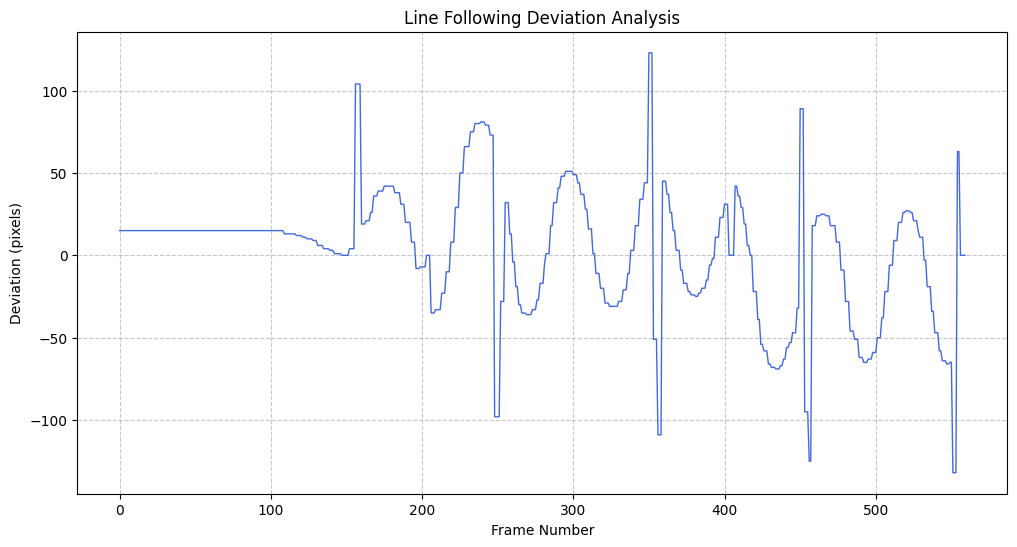

In [4]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

#we use data uploaded in moodle
def evaluate_performance():
    deviations = []
    frame_numbers = []
    data_dir = "proj_data"
    num_images = 560
    for i in range(num_images):
        img_path = os.path.join(data_dir, f"image_{i}.png")

        image = cv2.imread(img_path)
        if image is None:
            print(f"Warning: Failed to load image {i}")
            continue

        # preeprocesing
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)
        _, binary = cv2.threshold(blurred, 200, 255, cv2.THRESH_BINARY)

        kernel = np.ones((3,3), np.uint8)
        processed = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        processed = binary
        contours, _ = cv2.findContours(processed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if contours:
            largest_contour = max(contours, key=cv2.contourArea)
            M = cv2.moments(largest_contour)
            if M["m00"] != 0:
                cx = int(M["m10"] / M["m00"])
            else:
                cx = image.shape[1] // 2
        else:
            cx = image.shape[1] // 2
        robot_center_x = image.shape[1] // 2
        deviation = robot_center_x - cx
        deviations.append(deviation)
        frame_numbers.append(i)

    plt.figure(figsize=(12, 6))
    plt.plot(frame_numbers, deviations, color='royalblue', linewidth=1)
    plt.title("Line Following Deviation Analysis")
    plt.xlabel("Frame Number")
    plt.ylabel("Deviation (pixels)")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.savefig("performance_plot.png",
                dpi=300,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none')
    plt.show()

# teeeeeest!
evaluate_performance()

### B2. Deployment of Performance Metrics Functions
In the project descriptor, you were asked to measure accuracy of the line follower, that is how much the robot deviates from its intended path. The output of this function should be a plot which represents how the robot deviates from the line. For example, in the case of the down-cam sensor, you could calculate the distance of the centre of the robot from the centre of the white line (y-axis) in each frame (x-axis). Please enter the resulting plot (based on the performance of the standard line-following script provided in the Quanser Mobile Robotics downloads) in the cell below. Note to embed images in a Jupyter notebook you can use the following syntax (this will be explicitly visible in markdown mode):<img src="performance_plot.png" alt="Deviation Analysis" width="600"/>


Remember to upload the image files along with your submission on Moodle! Failing to do so will result in loss of marks for this section!